# The Final Challenge Problem

Zed City is a newly established (fictitious) municipality in Tokyo and is made up of 11 districts. <br/> 
Four convenience store ( _konbini_ ) chains A, B, C and D have each established their first store in this new city in non-overlapping districts.
The map (or graph) below shows the 11 districts of Zed City and which district has a konbini already.

Since this map looks different from a conventional one, let us explain how you should look at it once more just in case.<br/>
If you count the number of nodes in this map (or graph), you'll notice that there are 11 of them. So, you should be able to tell that each node in this map (or graph) represents one of the 11 districts of Zed city. The colored nodes are the districts that have konbinis already with each color representing a different konbini chain. In this graph, konbini chain A is represented in Red, B in Blue, C in Yellow and D in Green. Next, you should take notice of the edges that connect these nodes. Any node (district) connected to each other by an edge means that they are districts adjacent to each other.
<img src="./tokyo_map_pic.png" width="700">
As the mayor of Zed City, you want to establish konbinis in the rest of the districts that still don't have one yet.<br/>
Upon your request, all four konbini chains discussed with each other and agreed to establish their konbinis in Zed City under the following two conditions:

**-Only one konbini is allowed in one district.**<br/>
**-No two adjacent districts can have konbinis from the same chain.**<br/>

Can you come up with a plan that satisfies the above conditions? You must provide all store plan combinations that meet the conditions above.<br/>

**For solving this problem:**<br/>
- You must use the 32-qubit simulator as your backend. (i.e. backend = provider.get_backend('ibmq_qasm_simulator'))
- Use **Grover's algorithm** you learned in Week2 & 3 with **iteration ＝ 5.**
- Each konbini chain A, B, C and D should be described (mapped) as **A: $00$、B:$01$、C:$10$、D:$11$**.
- A konbini you are establishing in **district _n_**, should be mapped into classical registers **c[2n]** and **c[2n+1]**.
(For example, let's say you want to establish konbini chain B:$01$ into district n=1. In this case, you should map $0$ and $1$ into classical registers c[2] and c[3].)
- Make sure you **create an oracle** that **doesn't require any knowledge of what the answers are**. (For example, you are not allowed to create an oracle by using a classical optimization solver to get your answers for it.)  
- With the exception of the Unroller, which is required for decomposing your circuit to calculate quantum costs, you are not allowed to use any existing transpiler passes nor original transpilers for making simple simplifications in this competition.
- You are not allowed to use the reset operation (i.e. qc.reset()) in your circuit for this competition.
<br/><br/>
***************************

# Important notes and notations before we begin 

Let's write down the summary of the map of the Zed city in graph notation.

__Vertices:__ \[A, 0, 1, B, 2, 3, 4, C, 5, 6, D\]

__Edges:__ \[(A,0), (A,2), (A,3), (0,1), (0,2), (0,3), (1,B), (1,3), (1,4), (B,4), (2,3), (2,5), (2,6), (2,C), (3,4), (3,5), (3,6), (4,6), (C, D), (5,6), (5,D), (6,D)\]

We will express all 11 nodes in numeric notation for further convenience. Let us map A to 7, B to 8, C to 9, D to 10. So now we have the following graph

__Vertices:__ \[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10\]

__Edges:__ \[(7,0), (7,2), (7,3), (0,1), (0,2), (0,3), (1,8), (1,3), (1,4), (8,4), (2,3), (2,5), (2,6), (2,9), (3,4), (3,5), (3,6), (4,6), (9, 10), (5,6), (5,10), (6,10)\]

We will use two qubits to represent each district. The state of the pair of qubits encodes the konbini code. E.g. if the pair of qubits representing the 4th district is $10$, then there is a konbini store from the chain C in this district.

It looks like to solve the problem we will need to find all the possible ways to partition the graph into 4 groups of vertices, so that there are no edges in each group. Then each group can be used to assign one type of konbini store. In other words, we divide the graph into 4 groups such, that the number of edges going from one group to anuther is exactly equal to the number of edges in the graph (all edges are cut). So, this is basically a vertex coloring problem, where we need to find all possible colorings of the graph with 4 colors, given that 4 vertices have fixed colors.


Sort the edges in increasing order. We will need work with edges in batches (we cannot handle them all at once, since we have limitation on the number of qubits. The overall circuit need to have no more than 32 qubits). The way we will group them, is by the first vertex. So all edges starting with 0 are one batch, starting with 1 another batch, and so on.

In [1]:
# clean up edges
edges = [(7,0), (7,2), (7,3), (0,1), (0,2), (0,3), (1,8), (1,3), (1,4), (8,4), (2,3), (2,5), (2,6), (2,9), (3,4), (3,5), (3,6), (4,6), (9, 10), (5,6), (5,10), (6,10)]
edges_clean = []
for item in edges:
    if(item[0] > item[1]):
        new_item = (item[1], item[0])
    else:
        new_item = item
    edges_clean.append(new_item)
    
edges_clean.sort()
edges_clean

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 7),
 (1, 3),
 (1, 4),
 (1, 8),
 (2, 3),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 9),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 6),
 (4, 8),
 (5, 6),
 (5, 10),
 (6, 10),
 (9, 10)]

# Coding the solution
Naively, we need 22 qubits to encode the 11 districts. The last 8 ones will be initialized to reflect the presence of already established konbini stores (A: $00$, B:$01$, C:$10$, D:$11$). To produce all the possible distributions of konbini stores in the rest of districts we will initialize the first 14 qubits in a uniform superposition state.

In oracle the key part is to compare the colors of two vertices. Comparing two colors is comparing two 2-bit strings, and making sure that they are different. So this will include bitwise XOR on the two bit strings, then an OR over the result of the XOR.



## TODO: ##
#### Improvements: ###
* One possible improvement is to change the OR with AND ("a OR b = NOT((NOT a) AND (NOT b))"). This eliminates some CNOTs and adds some single qubit gates. the overall result is an improvement in the cost
* Improve the grouping

In [1]:
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit import QuantumCircuit

NUM_ITER = 5
EDGES = [(0, 1), (0, 2), (0, 3), (0, 7), (1, 3), 
         (1, 4), (1, 8), (2, 3), (2, 5), (2, 6), 
         (2, 7), (2, 9), (3, 4), (3, 5), (3, 6), 
         (3, 7), (4, 6), (4, 8), (5, 6), (5, 10), 
         (6, 10), (9, 10)]

def check_same_color(qc, q1, q2, q3, q4, a):
    qc.cx(q1, q3)
    qc.cx(q2, q4)
    qc.cx(q3, a)
    qc.cx(q4, a)
    qc.ccx(q3, q4, a)
    
def check_same_color_reverse(qc, q1, q2, q3, q4, a):
    qc.ccx(q3, q4, a)
    qc.cx(q4, a)
    qc.cx(q3, a)
    qc.cx(q2, q4)
    qc.cx(q1, q3)

def check_same_color_with_A(qc, q1, q2, a):
    qc.cx(q1, a)
    qc.cx(q2, a)
    qc.ccx(q1, q2, a)
    
def check_same_color_with_A_reverse(qc, q1, q2, a):
    qc.ccx(q1, q2, a)
    qc.cx(q2, a)
    qc.cx(q1, a)

def check_same_color_with_B(qc, q1, q2, a):
    qc.x(q2)
    qc.cx(q1, a)
    qc.cx(q2, a)
    qc.ccx(q1, q2, a)

def check_same_color_with_B_reverse(qc, q1, q2, a):
    qc.ccx(q1, q2, a)
    qc.cx(q2, a)
    qc.cx(q1, a)
    qc.x(q2)
    
def check_same_color_with_C(qc, q1, q2, a):
    qc.x(q1)
    qc.cx(q1, a)
    qc.cx(q2, a)
    qc.ccx(q1, q2, a)
    
def check_same_color_with_C_reverse(qc, q1, q2, a): 
    qc.ccx(q1, q2, a)
    qc.cx(q2, a)
    qc.cx(q1, a)
    qc.x(q1)

def check_same_color_with_D(qc, q1, q2, a):
    qc.x(q1)
    qc.x(q2)
    qc.cx(q1, a)
    qc.cx(q2, a)
    qc.ccx(q1, q2, a)
    
def check_same_color_with_D_reverse(qc, q1, q2, a):
    qc.ccx(q1, q2, a)
    qc.cx(q2, a)
    qc.cx(q1, a)
    qc.x(q2)
    qc.x(q1)



qdistricts = QuantumRegister(16, 'district')
qancilla = QuantumRegister(16, 'ancilla')
creg = ClassicalRegister(14)
qc = QuantumCircuit(qdistricts, qancilla, creg)

# prepare uniform superposition of all possible combinations.
qc.h(qdistricts[0:14])
qc.x(qdistricts[14])
qc.x(qancilla[15])
qc.h(qancilla[15])
qc.barrier()

for i in range(NUM_ITER):
    # create the oracle
    ##################################
    check_same_color(qc, qdistricts[4], qdistricts[5], qdistricts[6], qdistricts[7], qancilla[0])
    check_same_color(qc, qdistricts[4], qdistricts[5], qdistricts[10], qdistricts[11], qancilla[1])
    check_same_color(qc, qdistricts[4], qdistricts[5], qdistricts[12], qdistricts[13], qancilla[2])    
    check_same_color(qc, qdistricts[4], qdistricts[5], qdistricts[14], qdistricts[15], qancilla[3])
    check_same_color_with_A(qc, qdistricts[4], qdistricts[5], qancilla[4])
    
    qc.mct([qancilla[0], qancilla[1], qancilla[2], qancilla[3], qancilla[4]], qancilla[5], qancilla[12:15])
    
    check_same_color_with_A_reverse(qc, qdistricts[4], qdistricts[5], qancilla[4])
    check_same_color_reverse(qc, qdistricts[4], qdistricts[5], qdistricts[14], qdistricts[15], qancilla[3])
    check_same_color_reverse(qc, qdistricts[4], qdistricts[5], qdistricts[12], qdistricts[13], qancilla[2])
    check_same_color_reverse(qc, qdistricts[4], qdistricts[5], qdistricts[10], qdistricts[11], qancilla[1])
    check_same_color_reverse(qc, qdistricts[4], qdistricts[5], qdistricts[6], qdistricts[7], qancilla[0])
    #####################################
    
    ###################################
    check_same_color(qc, qdistricts[0], qdistricts[1], qdistricts[2], qdistricts[3], qancilla[0])
    check_same_color(qc, qdistricts[0], qdistricts[1], qdistricts[4], qdistricts[5], qancilla[1])
    check_same_color(qc, qdistricts[0], qdistricts[1], qdistricts[6], qdistricts[7], qancilla[2])
    check_same_color_with_A(qc, qdistricts[0], qdistricts[1], qancilla[3])
    
    qc.mct([qancilla[0], qancilla[1], qancilla[2], qancilla[3]], qancilla[6], qancilla[12:14])
    
    check_same_color_with_A_reverse(qc, qdistricts[0], qdistricts[1], qancilla[3])
    check_same_color_reverse(qc, qdistricts[0], qdistricts[1], qdistricts[6], qdistricts[7], qancilla[2])
    check_same_color_reverse(qc, qdistricts[0], qdistricts[1], qdistricts[4], qdistricts[5], qancilla[1])
    check_same_color_reverse(qc, qdistricts[0], qdistricts[1], qdistricts[2], qdistricts[3], qancilla[0])
    ############################
    
    ###########################
    check_same_color(qc, qdistricts[2], qdistricts[3], qdistricts[6], qdistricts[7], qancilla[0])
    check_same_color(qc, qdistricts[2], qdistricts[3], qdistricts[8], qdistricts[9], qancilla[1])
    check_same_color_with_B(qc, qdistricts[2], qdistricts[3], qancilla[2])
    
    qc.mct([qancilla[0], qancilla[1], qancilla[2]], qancilla[7], [qancilla[12]])
    
    check_same_color_with_B_reverse(qc, qdistricts[2], qdistricts[3], qancilla[2])
    check_same_color_reverse(qc, qdistricts[2], qdistricts[3], qdistricts[8], qdistricts[9], qancilla[1])
    check_same_color_reverse(qc, qdistricts[2], qdistricts[3], qdistricts[6], qdistricts[7], qancilla[0])
    ################################
    
    ##############################
    check_same_color(qc, qdistricts[6], qdistricts[7], qdistricts[8], qdistricts[9], qancilla[0])
    check_same_color(qc, qdistricts[6], qdistricts[7], qdistricts[10], qdistricts[11], qancilla[1])
    check_same_color(qc, qdistricts[6], qdistricts[7], qdistricts[12], qdistricts[13], qancilla[2])
    check_same_color_with_A(qc, qdistricts[6], qdistricts[7], qancilla[3])
    
    qc.mct([qancilla[0], qancilla[1], qancilla[2], qancilla[3]], qancilla[8], qancilla[12:14])
    
    check_same_color_with_A_reverse(qc, qdistricts[6], qdistricts[7], qancilla[3])
    check_same_color_reverse(qc, qdistricts[6], qdistricts[7], qdistricts[12], qdistricts[13], qancilla[2])
    check_same_color_reverse(qc, qdistricts[6], qdistricts[7], qdistricts[10], qdistricts[11], qancilla[1])
    check_same_color_reverse(qc, qdistricts[6], qdistricts[7], qdistricts[8], qdistricts[9], qancilla[0])
    #########################################################
    
    ########################################
    check_same_color(qc, qdistricts[8], qdistricts[9], qdistricts[12], qdistricts[13], qancilla[0])
    check_same_color_with_B(qc, qdistricts[8], qdistricts[9], qancilla[1])
    
    qc.ccx(qancilla[0], qancilla[1], qancilla[9])
    
    check_same_color_with_B_reverse(qc, qdistricts[8], qdistricts[9], qancilla[1])
    check_same_color_reverse(qc, qdistricts[8], qdistricts[9], qdistricts[12], qdistricts[13], qancilla[0])
    ########################################
    
    ########################################
    check_same_color(qc, qdistricts[10], qdistricts[11], qdistricts[12], qdistricts[13], qancilla[0])
    check_same_color_with_D(qc, qdistricts[10], qdistricts[11], qancilla[1])
    
    qc.ccx(qancilla[0], qancilla[1], qancilla[10])
    
    check_same_color_with_D_reverse(qc, qdistricts[10], qdistricts[11], qancilla[1])
    check_same_color_reverse(qc, qdistricts[10], qdistricts[11], qdistricts[12], qdistricts[13], qancilla[0])
    ########################################
    
    ########################################
    check_same_color_with_D(qc, qdistricts[12], qdistricts[13], qancilla[0])
    
    qc.cx(qancilla[0], qancilla[11])
    
    check_same_color_with_D_reverse(qc, qdistricts[12], qdistricts[13], qancilla[0])
    ########################################
    
    
    qc.mct(qancilla[5:12], qancilla[15], qancilla[0:5])
    
    
    ########################################
    
    
    ####################################
    ######FULL REVERSE##################
    ####################################
    check_same_color_with_D(qc, qdistricts[12], qdistricts[13], qancilla[0])
    
    qc.cx(qancilla[0], qancilla[11])
    
    check_same_color_with_D_reverse(qc, qdistricts[12], qdistricts[13], qancilla[0])
    ########################################
    
    ########################################
    check_same_color(qc, qdistricts[10], qdistricts[11], qdistricts[12], qdistricts[13], qancilla[0])
    check_same_color_with_D(qc, qdistricts[10], qdistricts[11], qancilla[1])
    
    qc.ccx(qancilla[0], qancilla[1], qancilla[10])
    
    check_same_color_with_D_reverse(qc, qdistricts[10], qdistricts[11], qancilla[1])
    check_same_color_reverse(qc, qdistricts[10], qdistricts[11], qdistricts[12], qdistricts[13], qancilla[0])
    ########################################
    
    ########################################
    check_same_color(qc, qdistricts[8], qdistricts[9], qdistricts[12], qdistricts[13], qancilla[0])
    check_same_color_with_B(qc, qdistricts[8], qdistricts[9], qancilla[1])
    
    qc.ccx(qancilla[0], qancilla[1], qancilla[9])
    
    check_same_color_with_B_reverse(qc, qdistricts[8], qdistricts[9], qancilla[1])
    check_same_color_reverse(qc, qdistricts[8], qdistricts[9], qdistricts[12], qdistricts[13], qancilla[0])
    ########################################
    
    #########################################################
    check_same_color(qc, qdistricts[6], qdistricts[7], qdistricts[8], qdistricts[9], qancilla[0])
    check_same_color(qc, qdistricts[6], qdistricts[7], qdistricts[10], qdistricts[11], qancilla[1])
    check_same_color(qc, qdistricts[6], qdistricts[7], qdistricts[12], qdistricts[13], qancilla[2])
    check_same_color_with_A(qc, qdistricts[6], qdistricts[7], qancilla[3])
    
    qc.mct([qancilla[0], qancilla[1], qancilla[2], qancilla[3]], qancilla[8], qancilla[12:14])
    
    check_same_color_with_A_reverse(qc, qdistricts[6], qdistricts[7], qancilla[3])
    check_same_color_reverse(qc, qdistricts[6], qdistricts[7], qdistricts[12], qdistricts[13], qancilla[2])
    check_same_color_reverse(qc, qdistricts[6], qdistricts[7], qdistricts[10], qdistricts[11], qancilla[1])
    check_same_color_reverse(qc, qdistricts[6], qdistricts[7], qdistricts[8], qdistricts[9], qancilla[0])
    ##############################
    
    ################################
    check_same_color(qc, qdistricts[2], qdistricts[3], qdistricts[6], qdistricts[7], qancilla[0])
    check_same_color(qc, qdistricts[2], qdistricts[3], qdistricts[8], qdistricts[9], qancilla[1])
    check_same_color_with_B(qc, qdistricts[2], qdistricts[3], qancilla[2])
    
    qc.mct([qancilla[0], qancilla[1], qancilla[2]], qancilla[7], [qancilla[12]])
    
    check_same_color_with_B_reverse(qc, qdistricts[2], qdistricts[3], qancilla[2])
    check_same_color_reverse(qc, qdistricts[2], qdistricts[3], qdistricts[8], qdistricts[9], qancilla[1])
    check_same_color_reverse(qc, qdistricts[2], qdistricts[3], qdistricts[6], qdistricts[7], qancilla[0])
    ###########################
    
    ############################
    check_same_color(qc, qdistricts[0], qdistricts[1], qdistricts[2], qdistricts[3], qancilla[0])
    check_same_color(qc, qdistricts[0], qdistricts[1], qdistricts[4], qdistricts[5], qancilla[1])
    check_same_color(qc, qdistricts[0], qdistricts[1], qdistricts[6], qdistricts[7], qancilla[2])
    check_same_color_with_A(qc, qdistricts[0], qdistricts[1], qancilla[3])
    
    qc.mct([qancilla[0], qancilla[1], qancilla[2], qancilla[3]], qancilla[6], qancilla[12:14])
    
    check_same_color_with_A_reverse(qc, qdistricts[0], qdistricts[1], qancilla[3])
    check_same_color_reverse(qc, qdistricts[0], qdistricts[1], qdistricts[6], qdistricts[7], qancilla[2])
    check_same_color_reverse(qc, qdistricts[0], qdistricts[1], qdistricts[4], qdistricts[5], qancilla[1])
    check_same_color_reverse(qc, qdistricts[0], qdistricts[1], qdistricts[2], qdistricts[3], qancilla[0])
    ###################################
    
    #####################################
    check_same_color(qc, qdistricts[4], qdistricts[5], qdistricts[6], qdistricts[7], qancilla[0])
    check_same_color(qc, qdistricts[4], qdistricts[5], qdistricts[10], qdistricts[11], qancilla[1])
    check_same_color(qc, qdistricts[4], qdistricts[5], qdistricts[12], qdistricts[13], qancilla[2])
    check_same_color(qc, qdistricts[4], qdistricts[5], qdistricts[14], qdistricts[15], qancilla[3])
    check_same_color_with_A(qc, qdistricts[4], qdistricts[5], qancilla[4])
    
    qc.mct([qancilla[0], qancilla[1], qancilla[2], qancilla[3], qancilla[4]], qancilla[5], qancilla[12:15])
    
    check_same_color_with_A_reverse(qc, qdistricts[4], qdistricts[5], qancilla[4])
    check_same_color_reverse(qc, qdistricts[4], qdistricts[5], qdistricts[14], qdistricts[15], qancilla[3])
    check_same_color_reverse(qc, qdistricts[4], qdistricts[5], qdistricts[12], qdistricts[13], qancilla[2])    
    check_same_color_reverse(qc, qdistricts[4], qdistricts[5], qdistricts[10], qdistricts[11], qancilla[1])
    check_same_color_reverse(qc, qdistricts[4], qdistricts[5], qdistricts[6], qdistricts[7], qancilla[0])

    
    ####################################
    ######FULL REVERSE END##############
    ####################################
    
    # inversion about mean
    qc.h(qdistricts)
    qc.x(qdistricts)
    
    qc.h(qdistricts[13])
    qc.mct(qdistricts[0:13], qdistricts[13], qancilla[0:11])
    qc.h(qdistricts[13])
    
    qc.x(qdistricts)
    qc.h(qdistricts)

qc.barrier()

# measurements
for i in range(14):
    qc.measure(qdistricts[i], creg[i])

#qc.draw(output='mpl')

In [2]:
# Count the operations

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc) 
#new_circuit.draw(output='mpl')
new_circuit.count_ops()

OrderedDict([('u3', 6797), ('cx', 5310), ('measure', 14), ('barrier', 2)])

In [ ]:
# run on IBM Q server with the commands and arguments provided by the challenge notebook

from qiskit import IBMQ
from qiskit import execute

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count = result.get_counts()
print(count)

d:\ibm quantum challenge 2019\python_venv\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


In [2]:
# get results from a job in IBM Q account

from qiskit import IBMQ

# get the latest job on your account
#provider = IBMQ.get_provider(hub='ibm-q')
#backend = provider.get_backend('ibmq_qasm_simulator')
#job = backend.jobs()[0]

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')
#job = backend.retrieve_job('5d9f9a509fa627001873bb66')
job = backend.retrieve_job('5da08f2c9e95940019e2c1ed')
job_result = job.result()

#counts = job.result().get_counts()
#counts_sorted = sorted(counts.items(), key=lambda x:x[1], reverse=True)
#counts_sorted[0:9]

# Code test area: #
*******************************

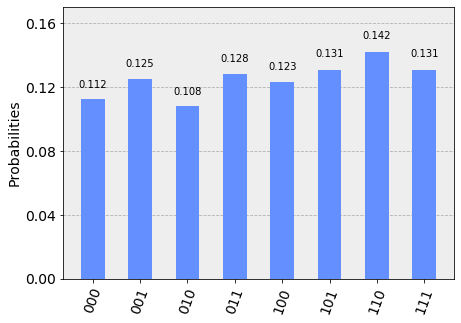

In [20]:
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit import execute

qreg = QuantumRegister(3)
creg = ClassicalRegister(3)
qc = QuantumCircuit(qreg, creg)

qc.h(qreg)
qc.measure(qreg, creg)

#qc.draw(output='mpl')

simulator = Aer.get_backend('qasm_simulator')
results = execute(qc, simulator).result()
from qiskit.tools.visualization import plot_histogram


plot_histogram(results.get_counts())

# Creating the submsision #
**************

In [4]:
# Input your quantum circuit
circuit = qc
# Input your result of the execute(groverCircuit, backend=backend, shots=shots).result()
results = job_result
count = results.get_counts()
# Provide your team name
name='Gate42'
# Please indicate the number of times you have made a submission so far. 
# For example, if it's your 1st time to submit your answer, write 1. If it's your 5th time to submit your answer, write 5.
times='1'

In [5]:
import json
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroll the circuit
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(circuit) 

# obtain gates
gates=new_circuit.count_ops()

#sort count
count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)

# collect answers with Top 9 probability
ans_list = count_sorted[0:9]

# reverse ans_list
ans_reversed = []
for i in ans_list:
    ans_temp=[i[0][::-1],i[1]]
    ans_reversed.append(ans_temp)

# convert each 2 bits into corresponding color. Add node0(0),node3(1),node8(2) and node11(3)
ans_shaped = []
for j in ans_reversed:
    ans_temp=j[0]
    nodeA = 0
    node0 = int(ans_temp[0] + ans_temp[1], 2)
    node1 = int(ans_temp[2] + ans_temp[3], 2)
    nodeB = 1
    node2 = int(ans_temp[4] + ans_temp[5], 2)
    node3 = int(ans_temp[6] + ans_temp[7], 2)
    node4 = int(ans_temp[8] + ans_temp[9], 2)
    nodeC = 2
    node5 = int(ans_temp[10] + ans_temp[11], 2)
    node6 = int(ans_temp[12] + ans_temp[13], 2)
    nodeD = 3
    nodes_color = str(nodeA) + str(node0) + str(node1) + str(nodeB) + str(node2) + str(node3) + str(node4) + str(nodeC) + str(node5) + str(node6) + str(nodeD) 
    ans_shaped.append([nodes_color,j[1]])

# write the result into '[your name]_final_output.txt'
filename=name+'_'+times+'_final_output.txt'
dct={'ans':ans_shaped,'costs':gates}
with open(filename, 'w') as f:
    json.dump(dct, f)

# Verification program #
**********

In [7]:
your_path='D:\IBM Quantum Challenge 2019\IBM-Quantum-Challenge-2019\Gate42_1_final_output.txt'
import json
from pathlib import Path

p= Path(your_path)

# Verify your information
f_name=p.name
your_info=f_name.split('_')
print('Your name: ', your_info[0])
print('The number of times you have submitted your answer: ', your_info[1])

with open(p, 'r') as f:
    print(f)
    your_ans=json.load(f)

print('Does your submission file have 9 answers?')
if (len(your_ans['ans'])!=9):
    print('- No, make sure you have 9 answers with top 9 probabilities')
else:
    print('- Yes')
    print('- Your plan: ', your_ans['ans'])

print('What is your cost?')
your_cost=your_ans['costs']['u3'] + 10*your_ans['costs']['cx']

Your name:  Gate42
The number of times you have submitted your answer:  1
<_io.TextIOWrapper name='D:\\IBM Quantum Challenge 2019\\IBM-Quantum-Challenge-2019\\Gate42_1_final_output.txt' mode='r' encoding='cp1252'>
Does your submission file have 9 answers?
- Yes
- Your plan:  [['01013232013', 63], ['02013132023', 62], ['01313202013', 61], ['01013232103', 61], ['02013122203', 59], ['02013132203', 57], ['02313122203', 56], ['02313102023', 53], ['02011322203', 48]]
What is your cost?


In [8]:
your_cost

59897